# Film Junky Union Project

<div style="border: 2px solid black; padding: 10px; margin: 10px">

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

</div>

## Initialization

In [6]:
import math
import re

import numpy as np
import pandas as pd
import spacy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report

from tqdm.auto import tqdm
from lightgbm import LGBMClassifier

import nltk
from nltk.corpus import stopwords

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-darkgrid')

In [8]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration

tqdm.pandas()

## Load Data

In [12]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Let's check the number of movies and reviews over years.

</div>

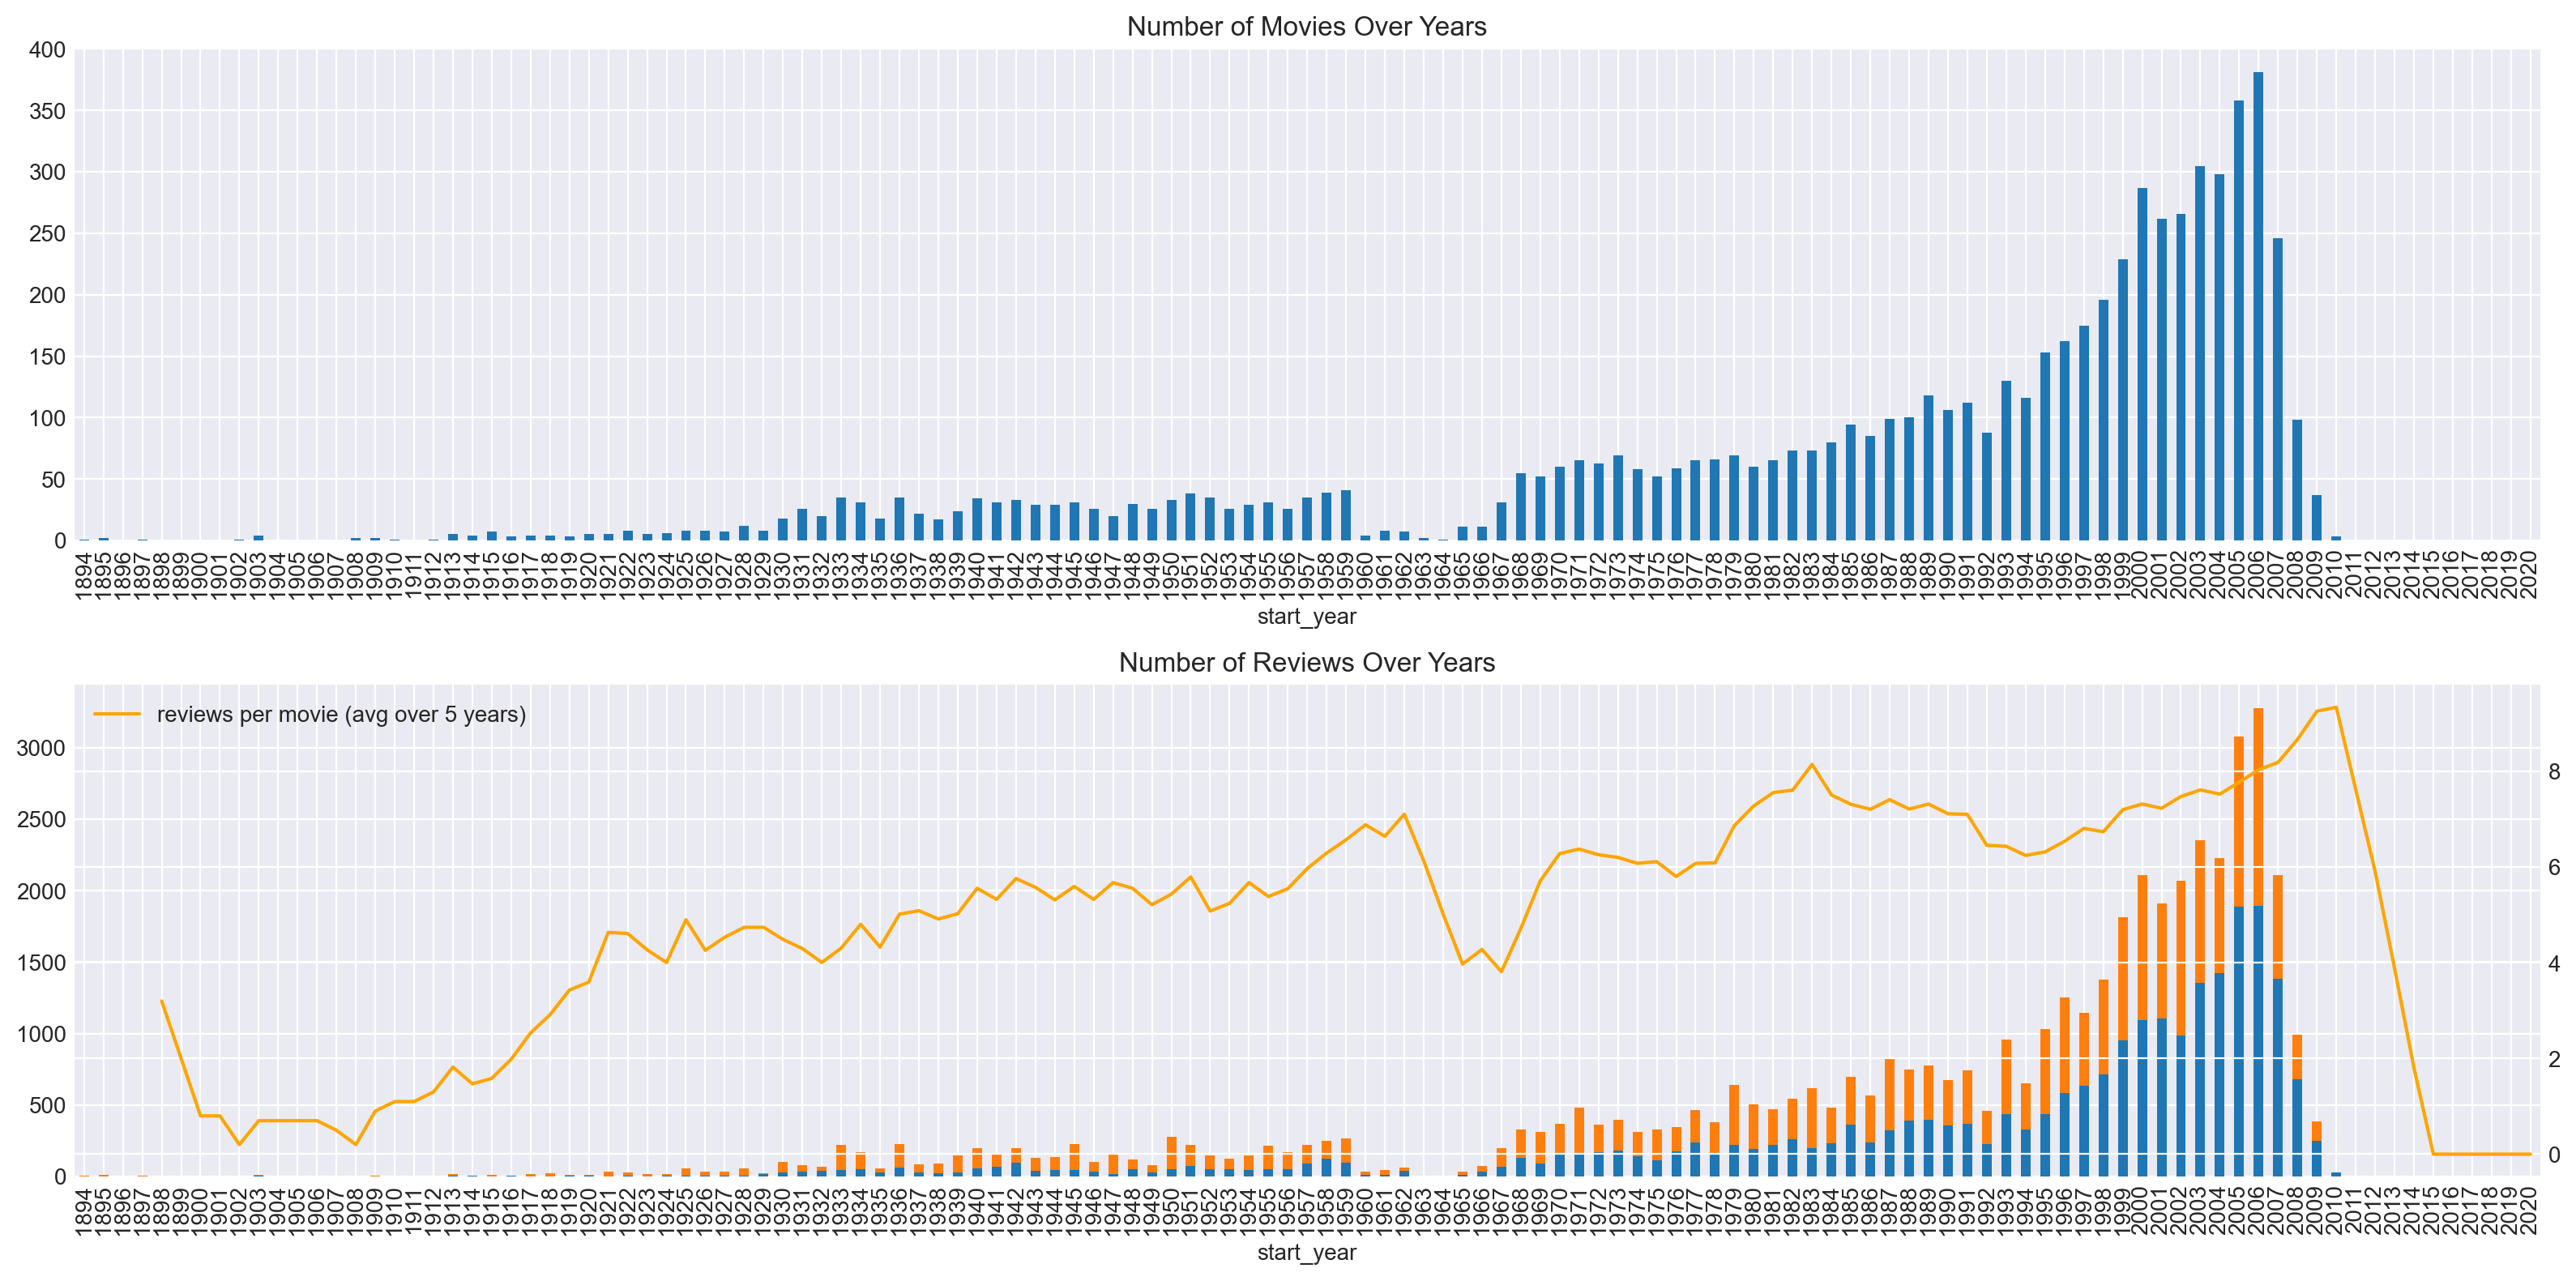

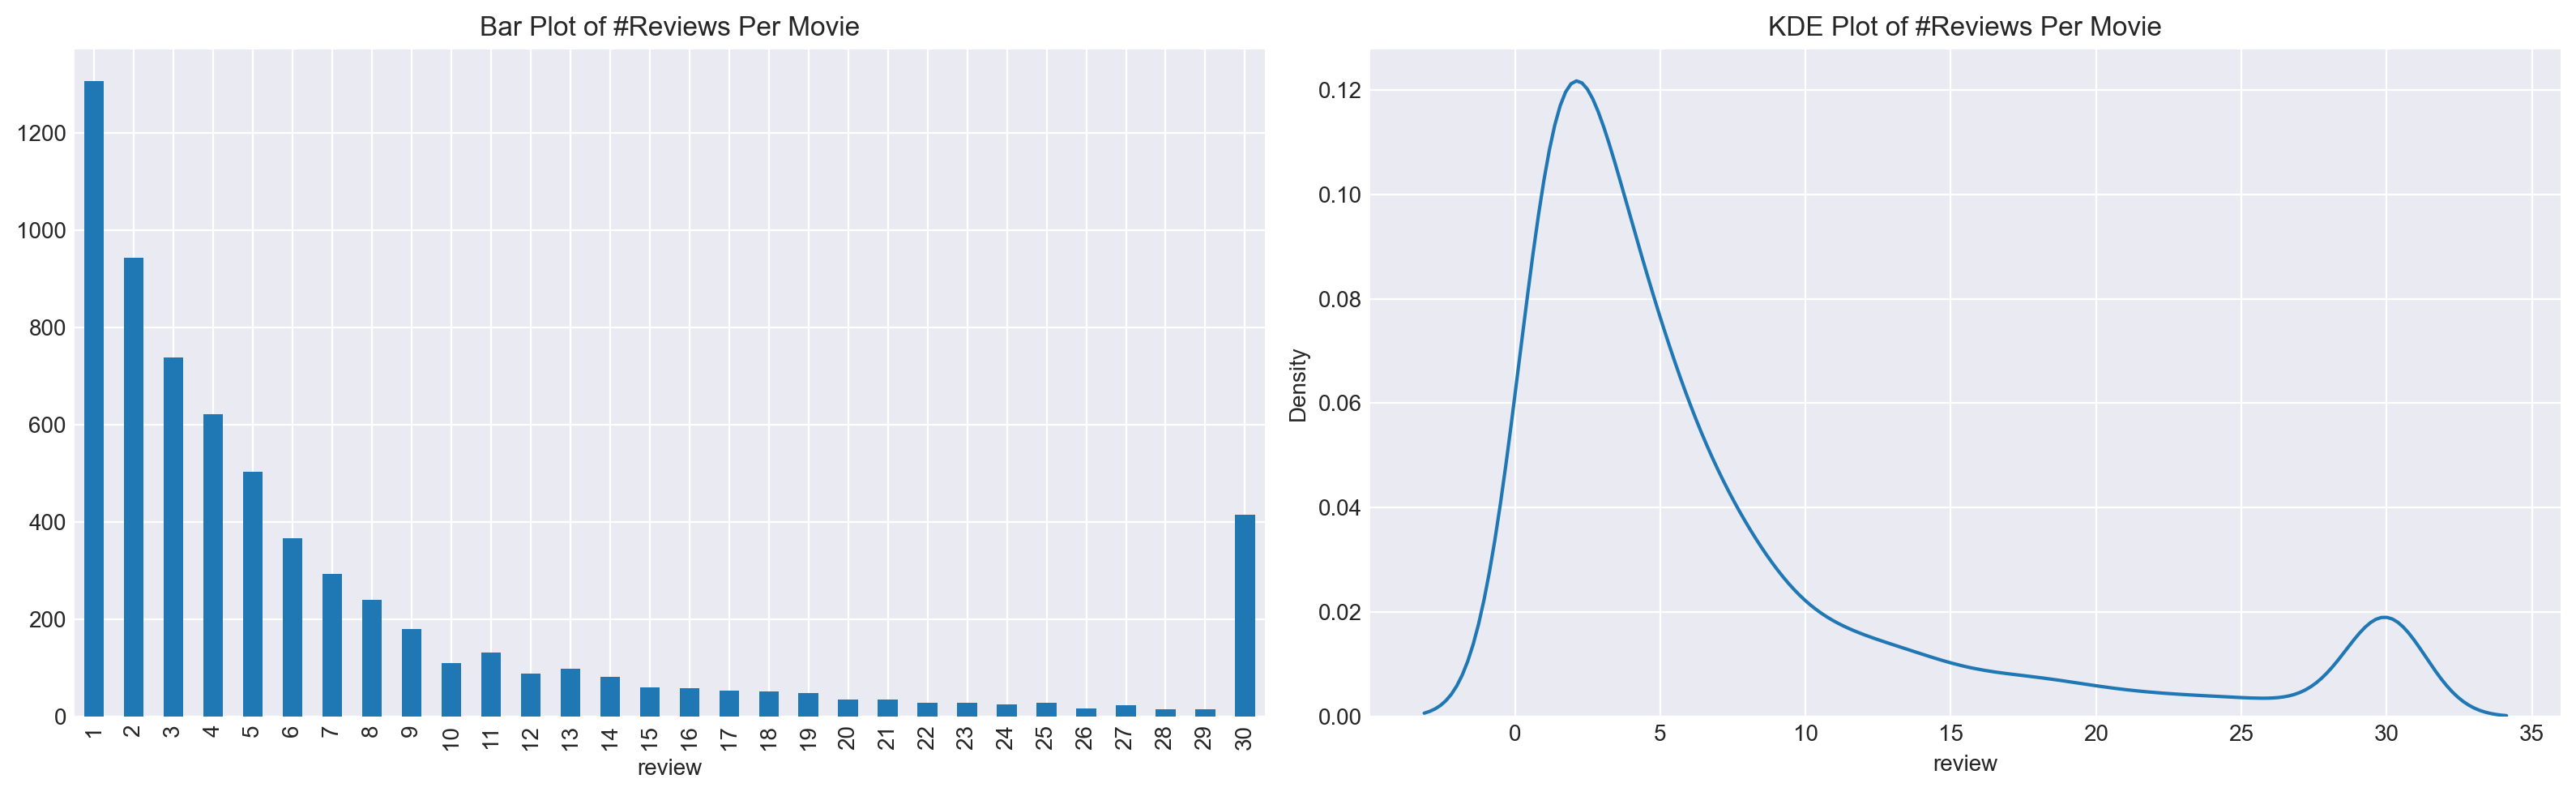

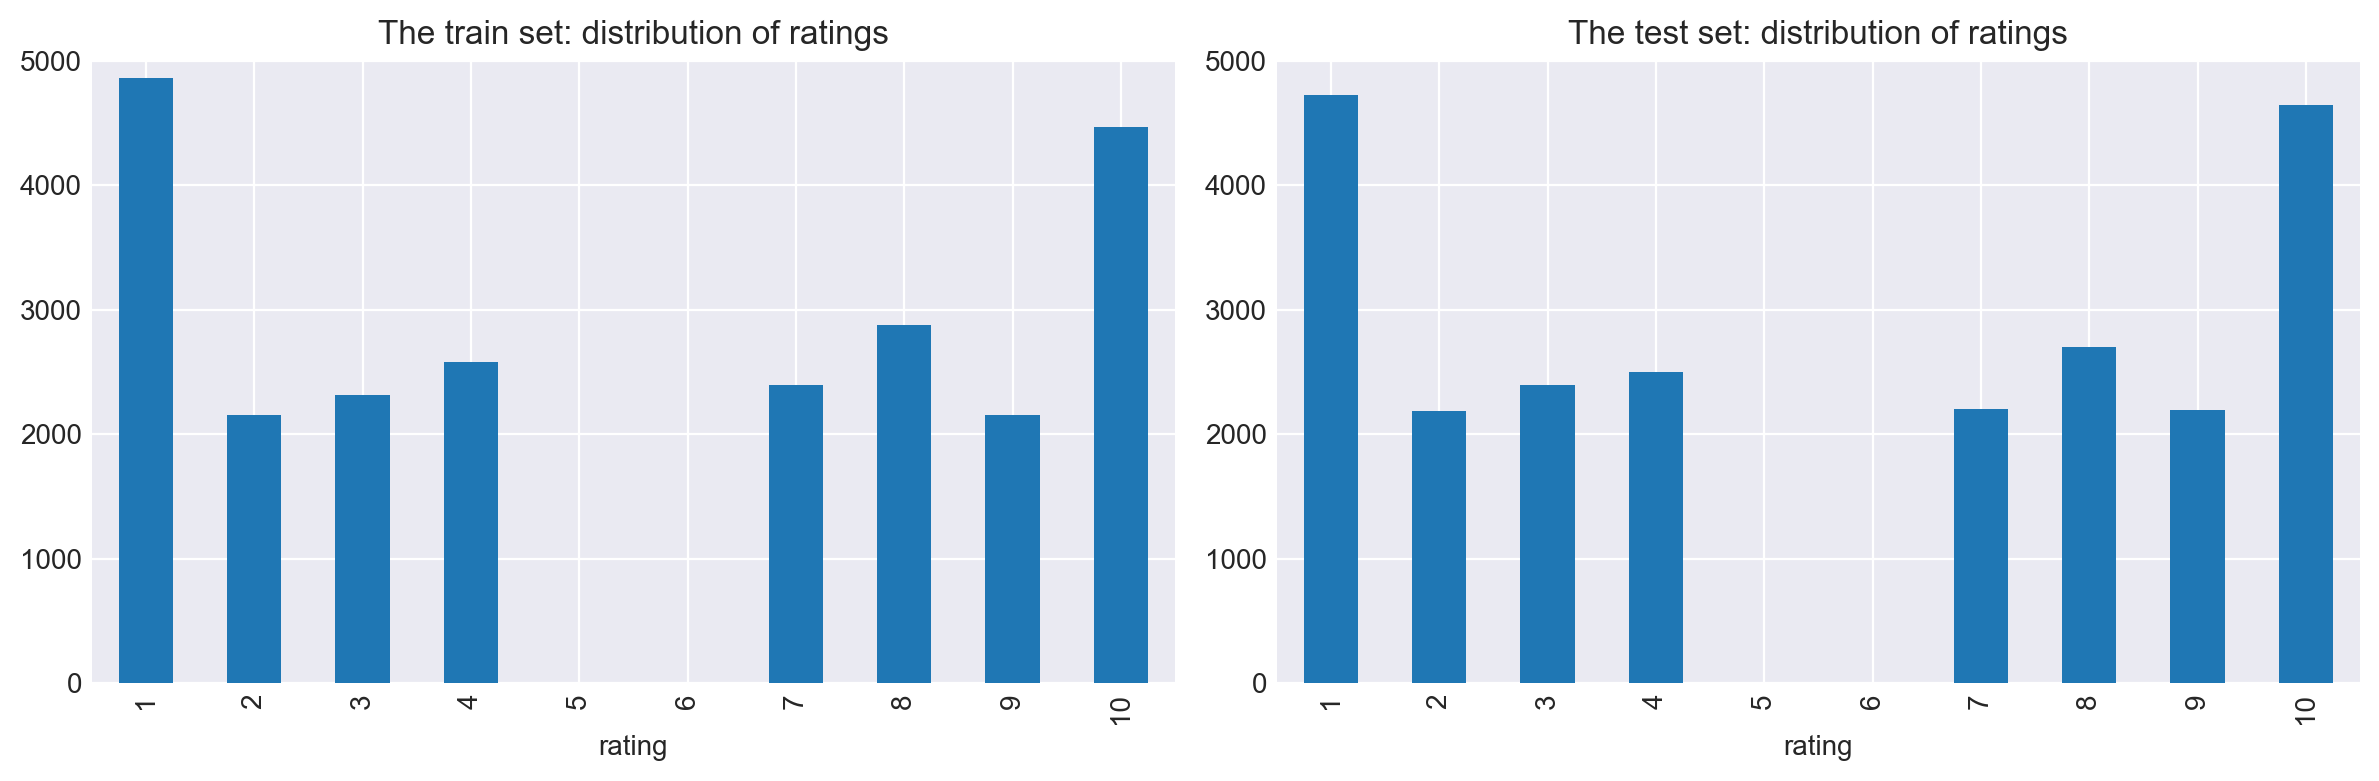

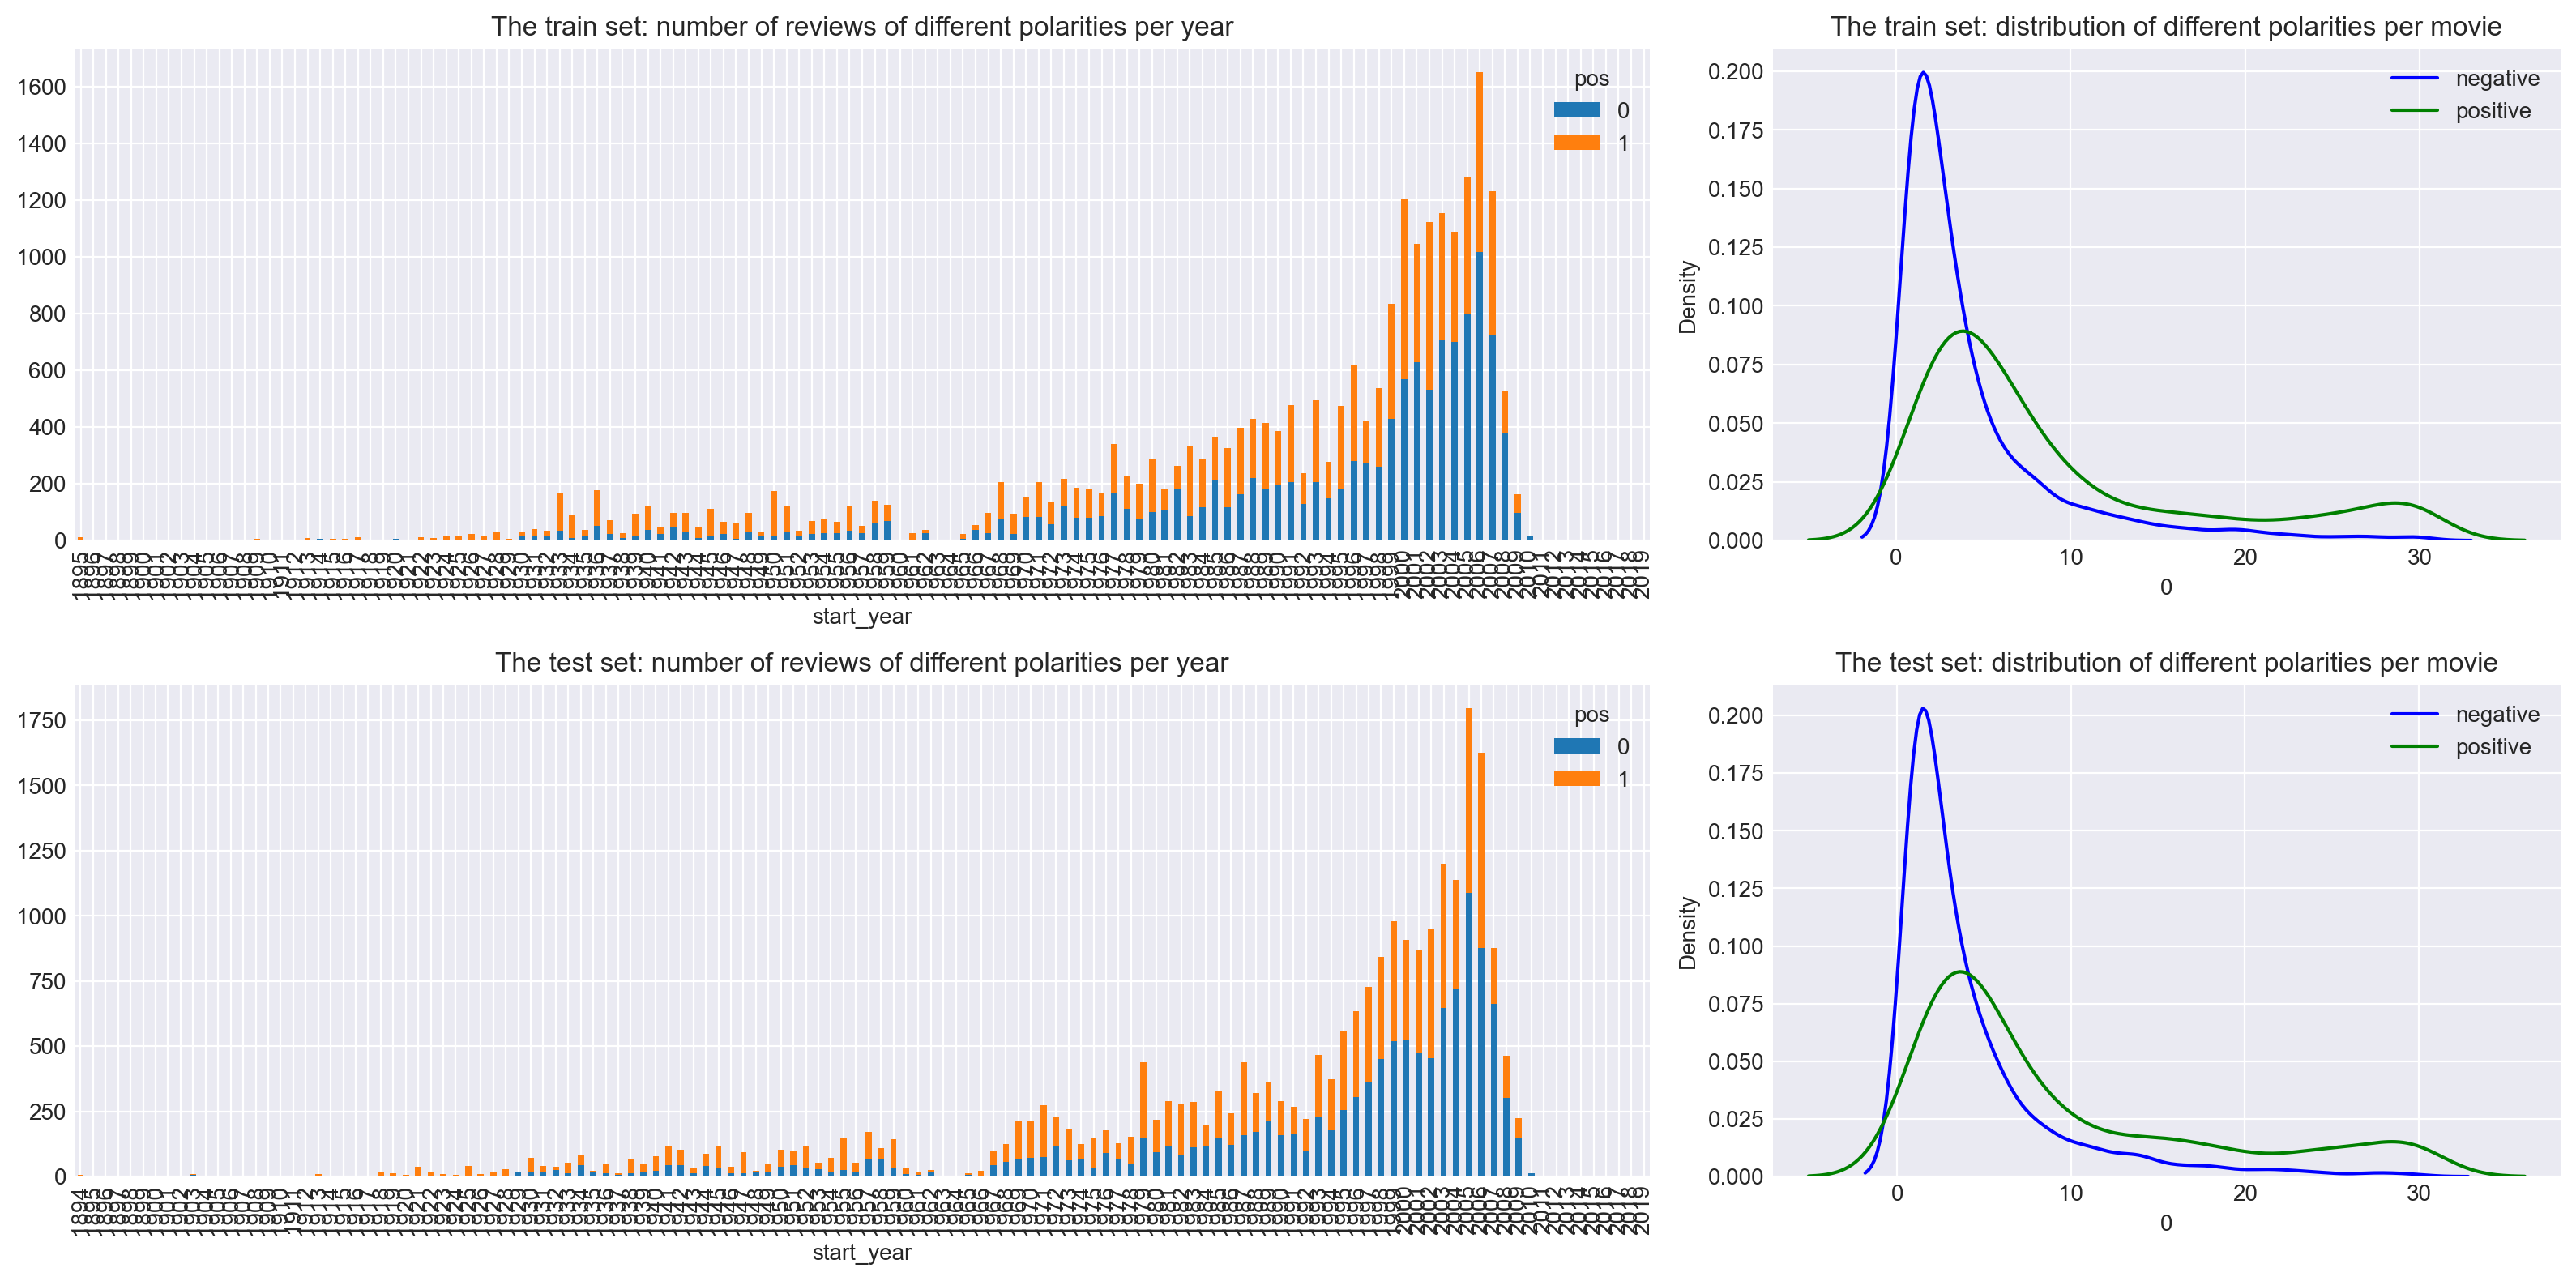

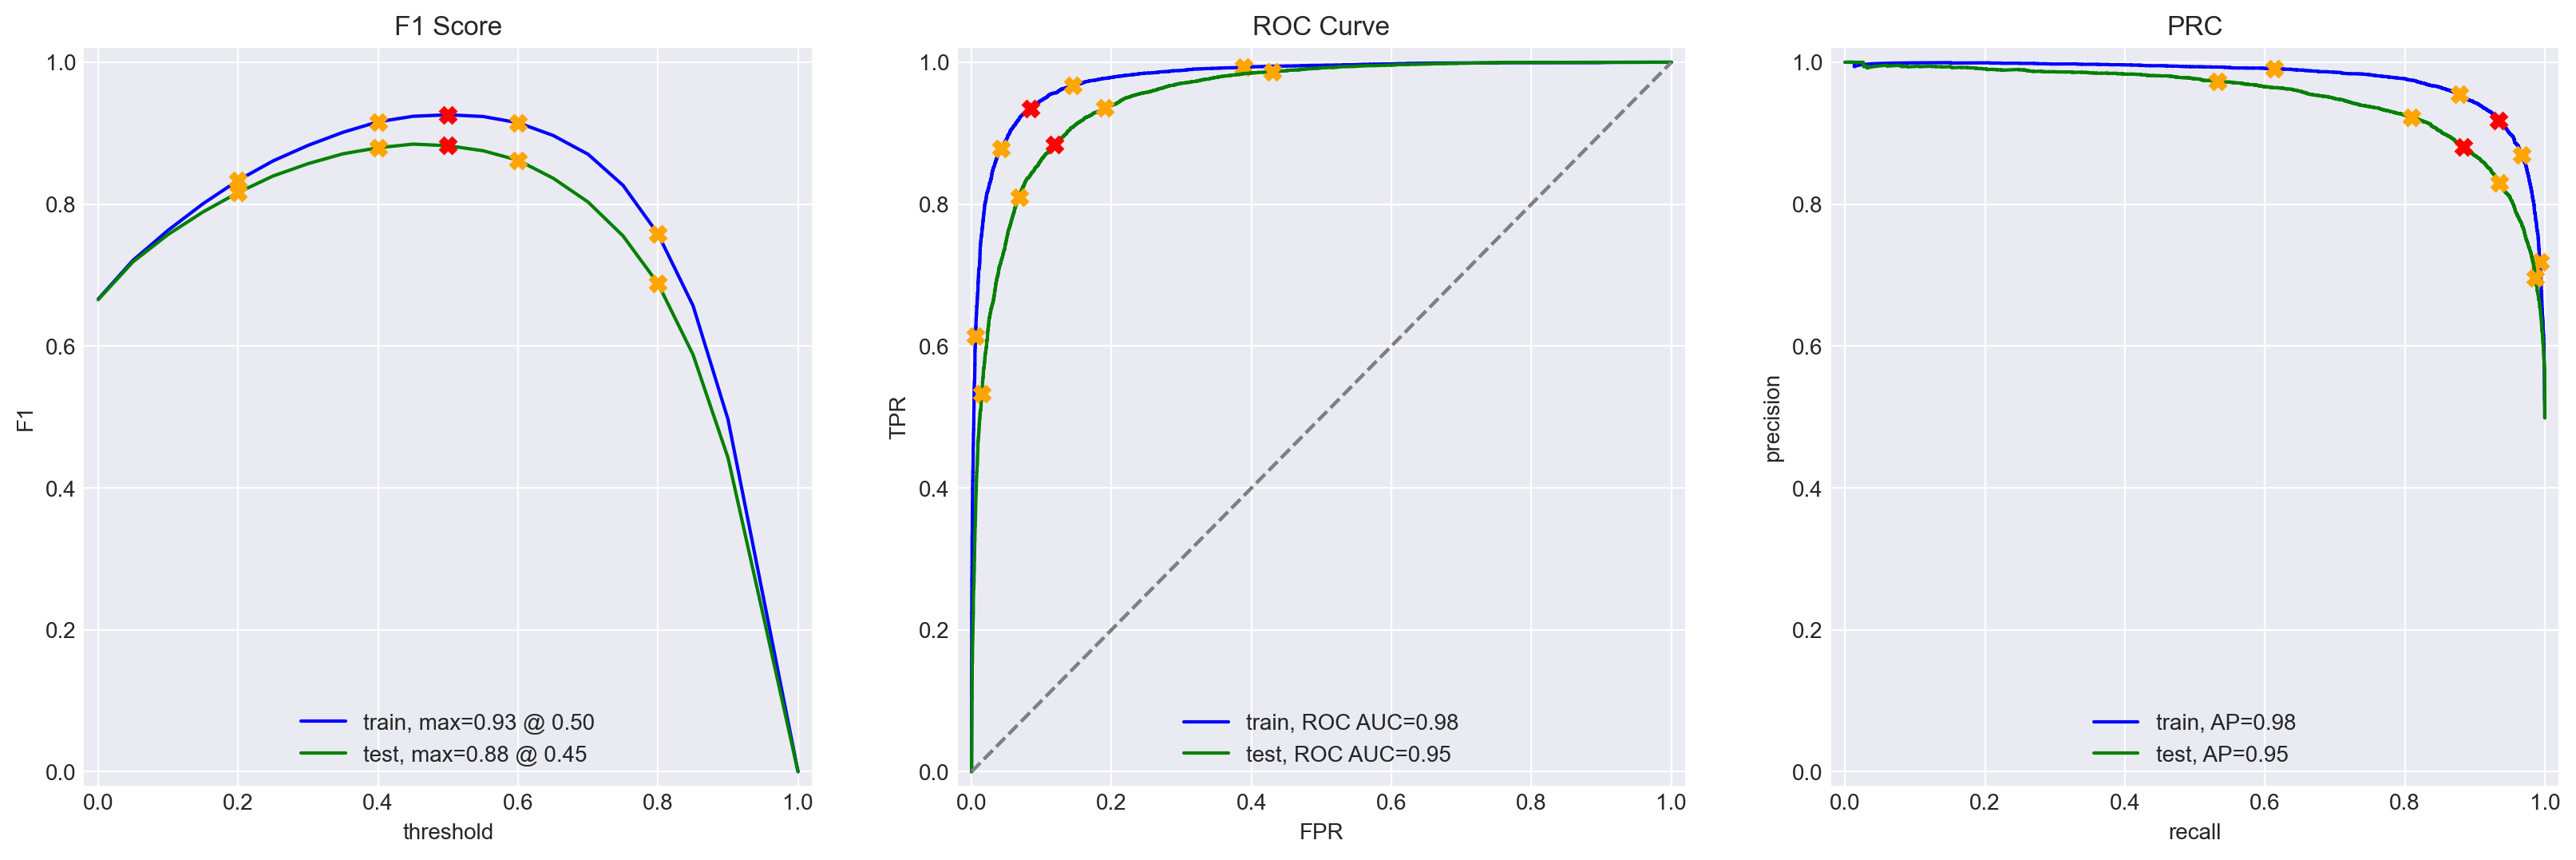

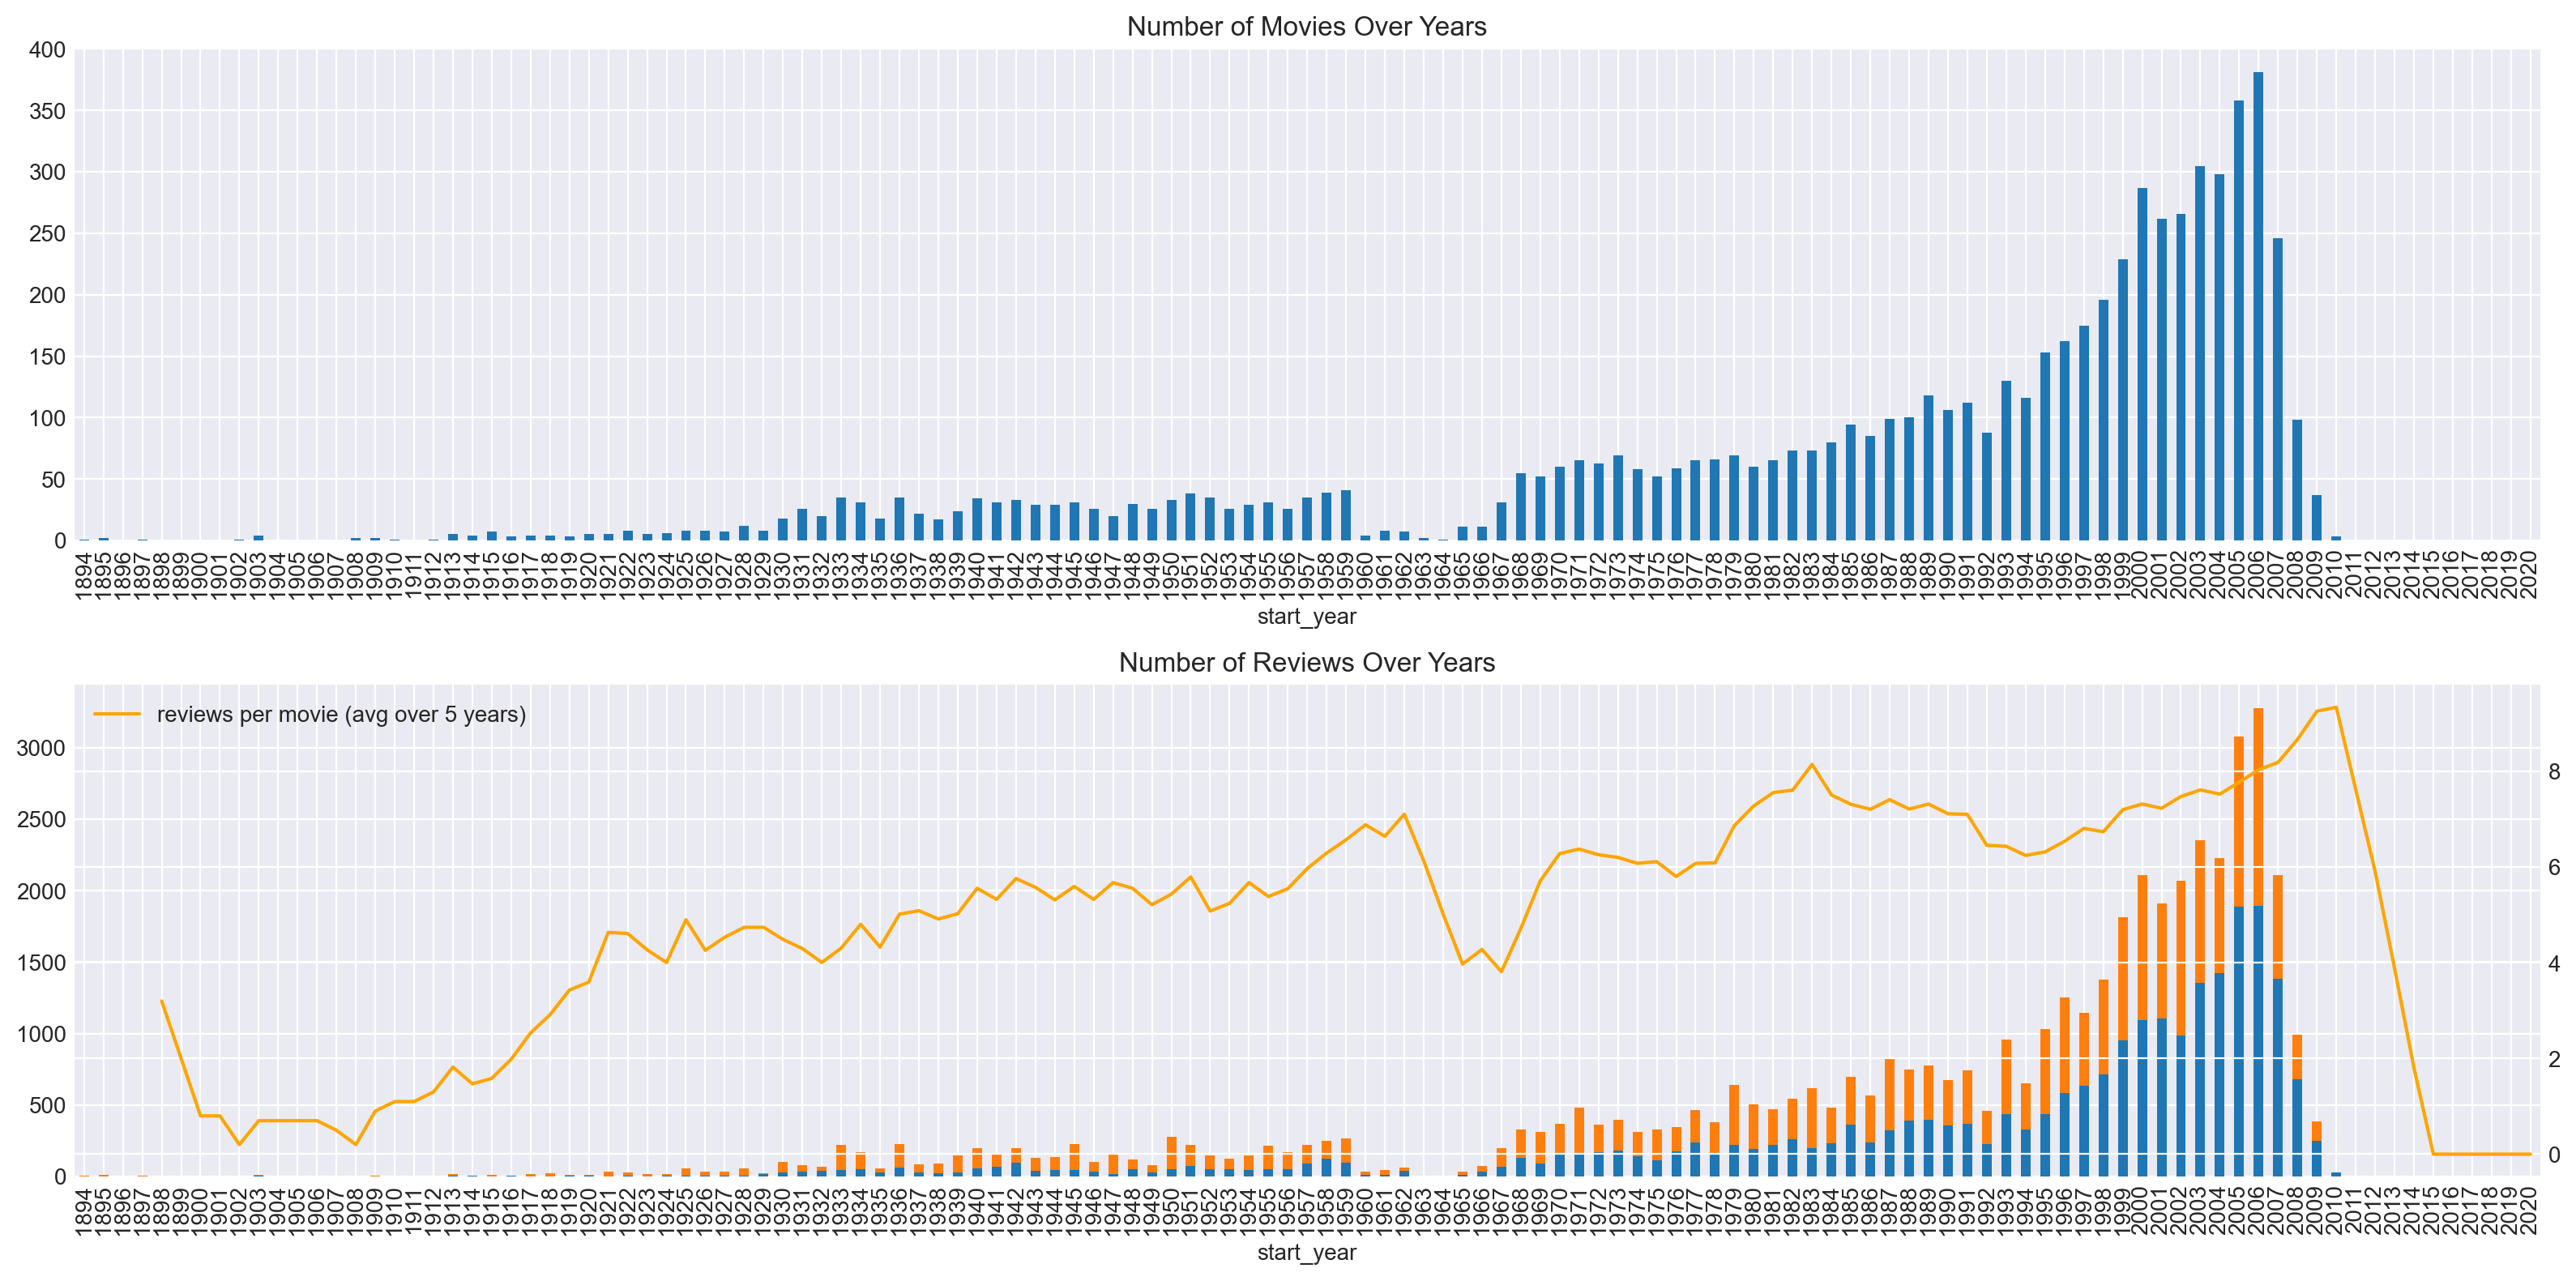

In [71]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

plt.show()

<div style="border: 3px solid black; padding: 15px; margin: 10px">

Here, we're seeing a distribution of the number of movies over the years and after the number of reviews for those movies. We can see a similar pattern in reviews versus amount of movies which helps give us an understanding of the data we're working with.


    
</div>

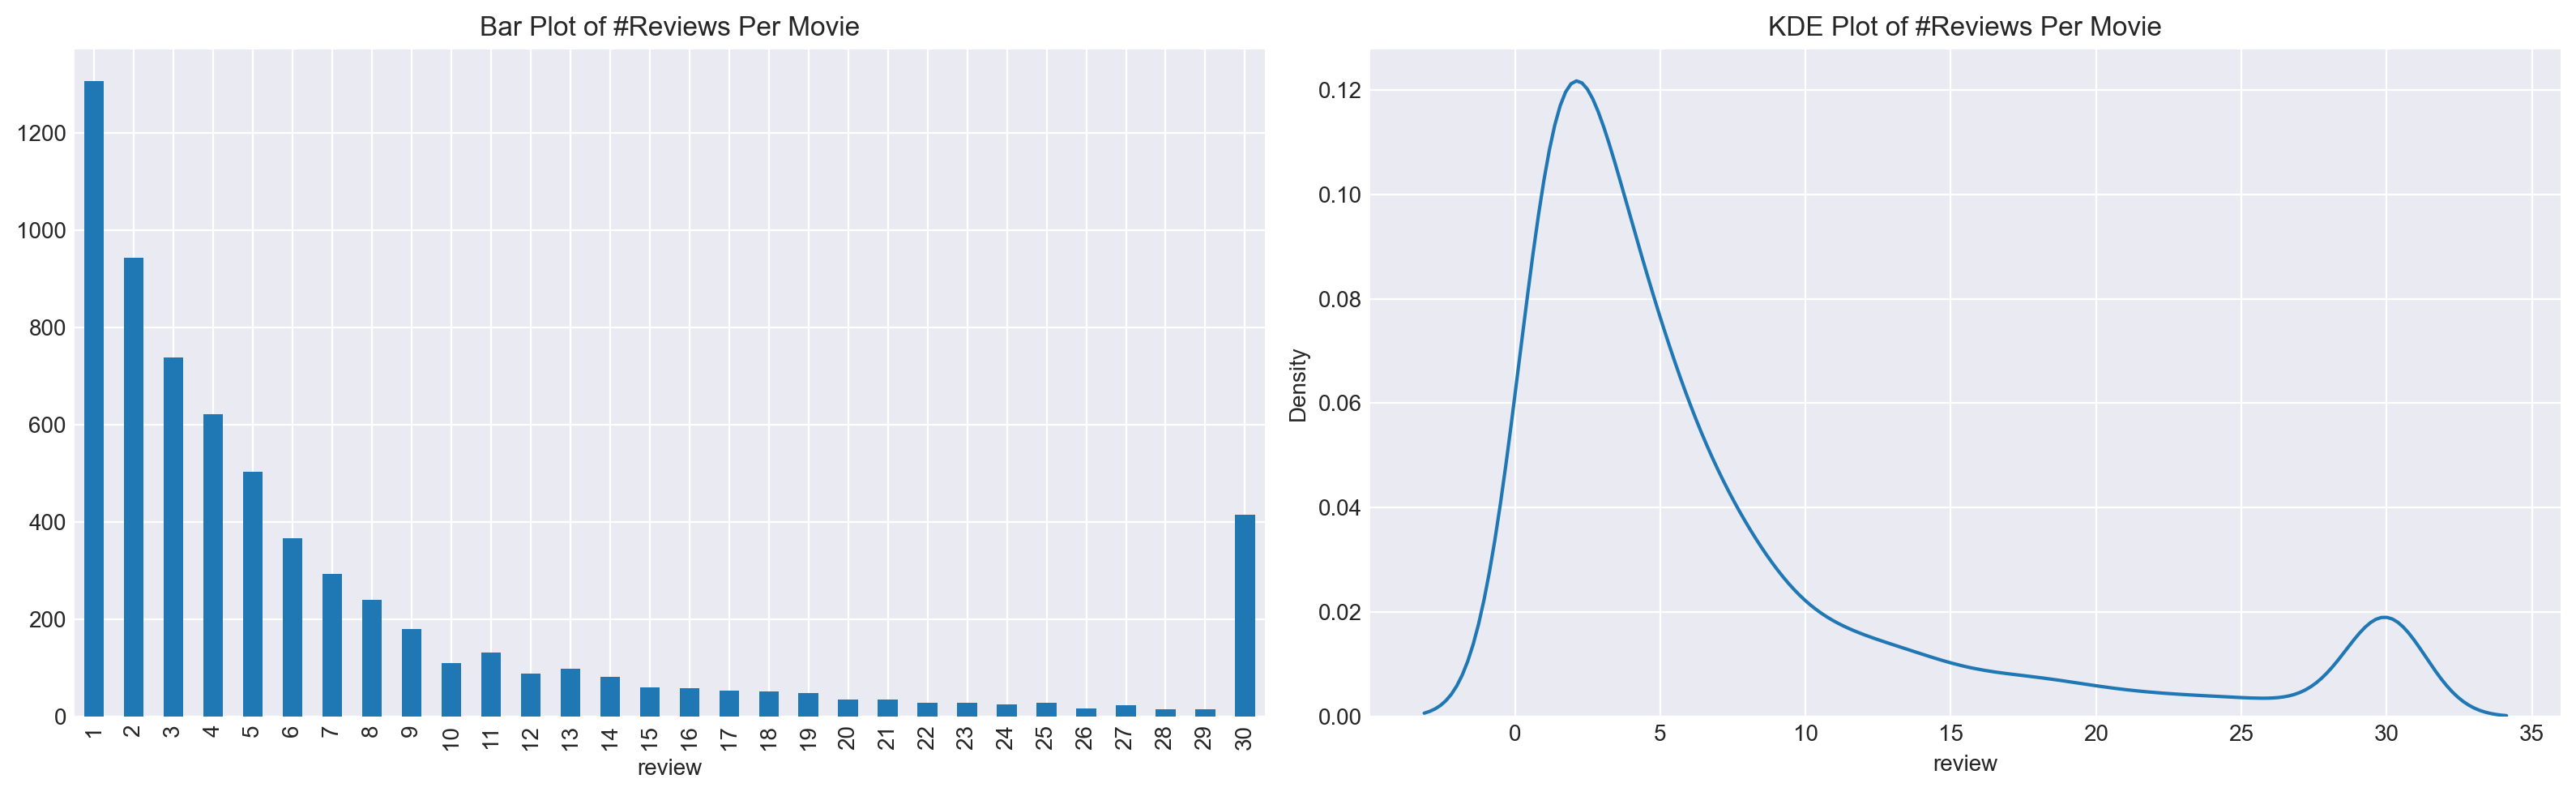

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

plt.show()

<div style="border: 3px solid black; padding: 15px; margin: 10px">

As we see here, the training and test sets are both very similar in terms of the distributions of "positive" and "negative" reviews. This is important so that when we train, and later test the model on the test sets, we'll have a more realistic diagnosis of the model's performance because of the data.


    
</div>

In [25]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

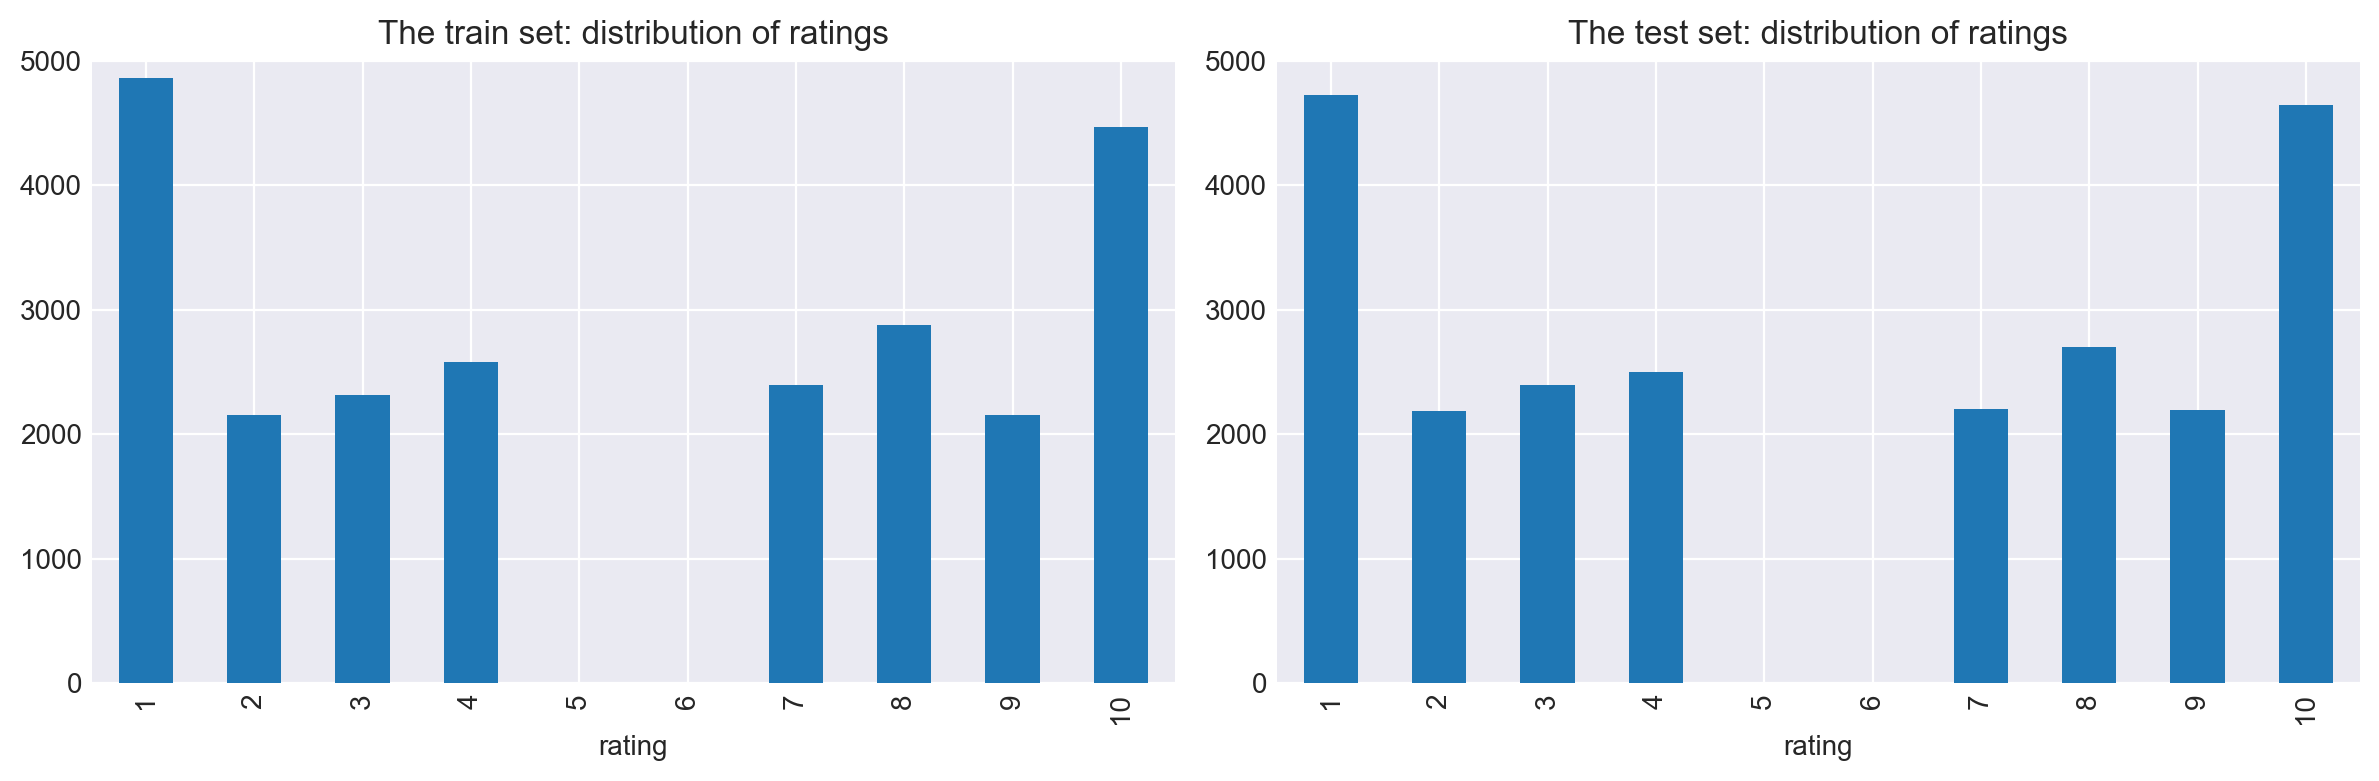

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

plt.show()

<div style="border: 3px solid black; padding: 15px; margin: 10px">

We can see here that the distribution of ratings for the training and test sets are similar as well leading towards an equally distributed dataset for both. The high amounts of ratings for "1" and "10" show the polarity of the tendency of people who are leaving the reviews.


    
</div>

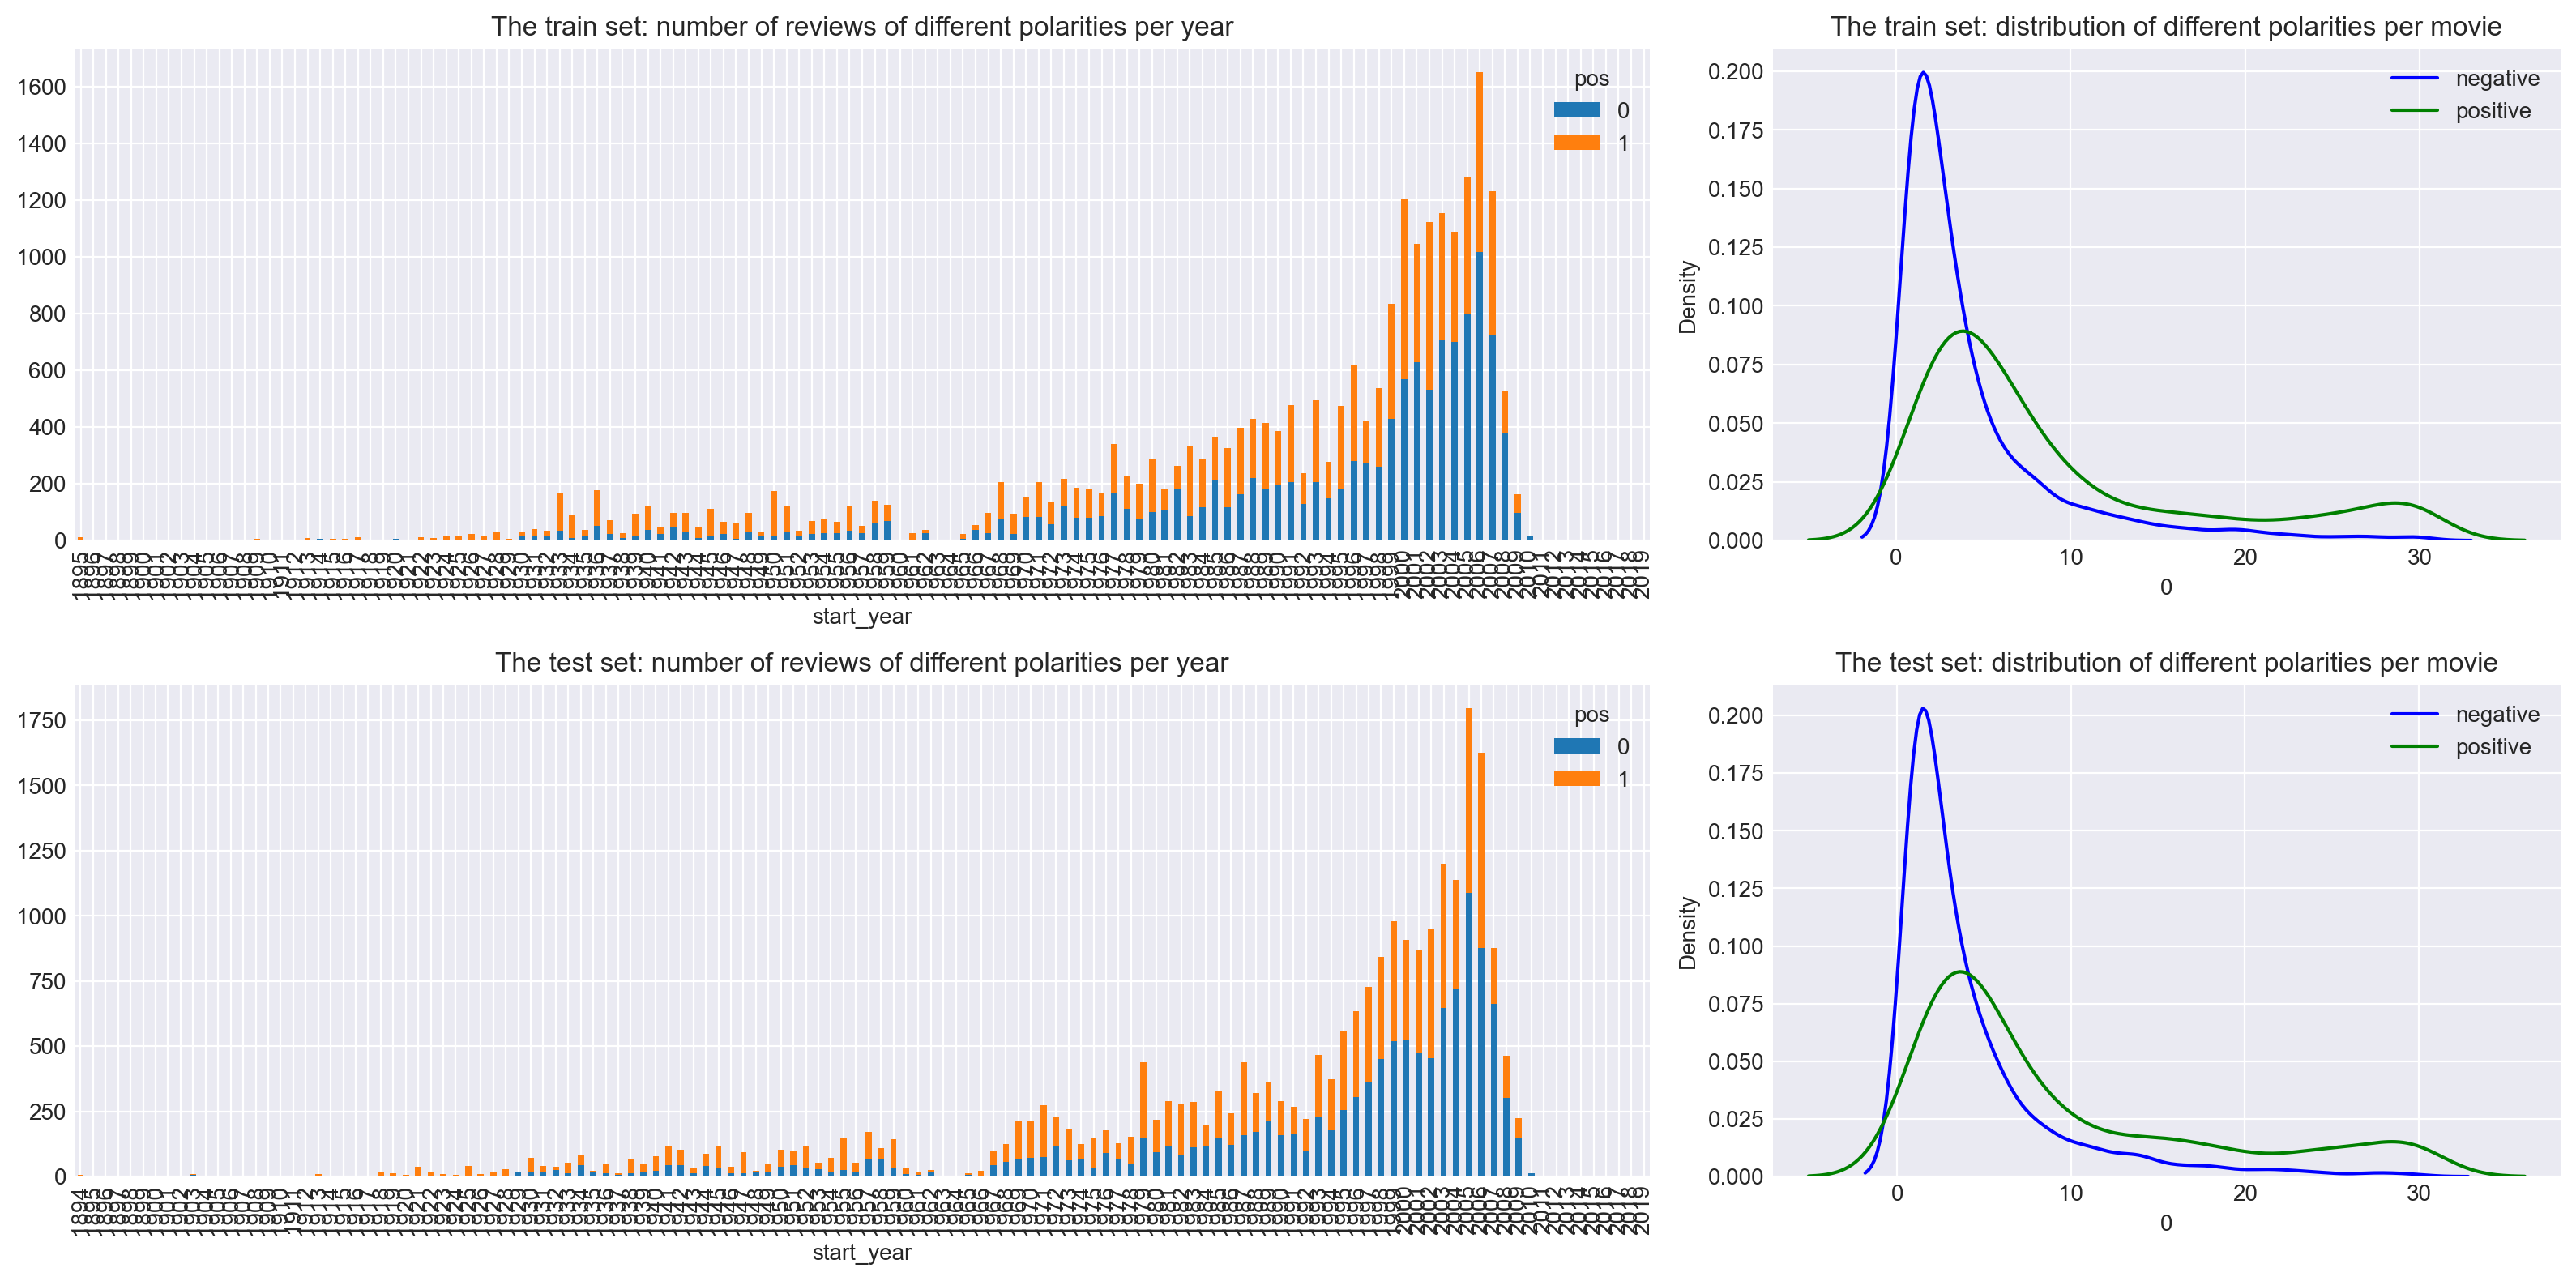

In [81]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

plt.show()

<div style="border: 3px solid black; padding: 15px; margin: 10px">

As we see here, the training and test sets are both very similar in terms of the distributions of "positive" and "negative" reviews. This is important so that when we train, and later test the model on the test sets, we'll have a more realistic diagnosis of the model's performance because of the data.


    
</div>

## Evaluation Procedure

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Composing an evaluation routine which can be used for all models in this project

</div>

In [37]:
# Creating evaluation function

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

<div style="border: 2px solid black; padding: 10px; margin: 10px">

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

</div>

In [41]:
# Normalizing the text with a function

def normalize_text(text):
    text = text.lower()                      # making everything lower case
    text = re.sub(r'[^a-z\s]', '', text)     # keeping only letters and spaces  
    text = re.sub(r'\s+', ' ', text).strip()  # removing extra spaces
    return text

# Applying to dataframe
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## Train / Test Split

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

</div>

In [45]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [48]:
# Converting text into numberical features (TF-IDF)

vectorizer = TfidfVectorizer(max_features=10000)

X_train = vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test = vectorizer.transform(df_reviews_test['review_norm'])

# Our Baseline Model as a Dunny Classifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, train_target)

y_pred_dummy = dummy.predict(X_test)

print("=== Model 0: Dummy Classifier ===")
print("Dummy F1 Score (macro):", f1_score(test_target, y_pred_dummy, average='macro'))
print(classification_report(test_target, y_pred_dummy, zero_division=0))

=== Model 0: Dummy Classifier ===
Dummy F1 Score (macro): 0.3340030562001245
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11803
           1       0.00      0.00      0.00     11732

    accuracy                           0.50     23535
   macro avg       0.25      0.50      0.33     23535
weighted avg       0.25      0.50      0.34     23535



<div style="border: 3px solid black; padding: 15px; margin: 10px">


As we look at our Constant Model, we see that it does not perform well in regards to the F1-Scores. This is a good baseline, though, to be able to compare with future models in this project.

    
</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [55]:
# Making sure stopwords is downloaded
nltk.download("stopwords")
stop_words = stopwords.words("english")

# Convert text into TF-IDF features with NLTK stopwords removed
vectorizer_1 = TfidfVectorizer(max_features=10000, stop_words=stop_words)

train_features_1 = vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = vectorizer_1.transform(df_reviews_test['review_norm'])

# Logistic Regression Model
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(train_features_1, train_target)

# Predictions
y_pred_1 = model_1.predict(test_features_1)

# Evaluation
print("=== Model 1: NLTK + TF-IDF + Logistic Regression ===")
print("F1 Score (macro):", f1_score(test_target, y_pred_1, average="macro", zero_division=0))
print(classification_report(test_target, y_pred_1, zero_division=0))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewmendez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Model 1: NLTK + TF-IDF + Logistic Regression ===
F1 Score (macro): 0.8825150963103225
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11803
           1       0.88      0.88      0.88     11732

    accuracy                           0.88     23535
   macro avg       0.88      0.88      0.88     23535
weighted avg       0.88      0.88      0.88     23535



In [56]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


<div style="border: 3px solid black; padding: 15px; margin: 10px">

From the looks of our graphs above, our first model performed very well. Accuracy for both Training and Test sets are considerable and the F1 Scores for both are above the minimum value required for model training.

    
</div>

### Model 2 - spaCy, TF-IDF and LR

In [89]:
# Loading spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])

In [91]:
# Preprocessing function (lemmatization)

def preprocess_texts_spacy(texts):
    docs = nlp.pipe(texts, batch_size=1000, n_process=-1) 
    return [" ".join([token.lemma_ for token in doc if not token.is_stop]) for doc in docs]

In [93]:
# Apply preprocessing
df_reviews_train["review_spacy"] = preprocess_texts_spacy(df_reviews_train["review_norm"])
df_reviews_test["review_spacy"] = preprocess_texts_spacy(df_reviews_test["review_norm"])



# Truncating words for this model to reduce processing time

def truncate_words(s, n=200):
    s = "" if s is None else str(s)
    return " ".join(s.split()[:n])

df_reviews_train['review_norm'] = df_reviews_train['review_norm'].map(lambda x: truncate_words(x, n=200))
df_reviews_test['review_norm']  = df_reviews_test['review_norm'].map(lambda x: truncate_words(x, n=200))



# TF-IDF
vectorizer_2 = TfidfVectorizer(max_features=1000, stopwords='english')
X_train_2 = vectorizer_2.fit_transform(df_reviews_train["review_spacy"])
X_test_2 = vectorizer_2.transform(df_reviews_test["review_spacy"])

# Logistic Regression
model_2 = LogisticRegression(max_iter=50, solver='saga', n_jobs=-1)
model_2.fit(X_train_2, train_target)

# Predictions
y_pred_2 = model_2.predict(X_test_2)

# Evaluation
print("=== Model 2: spaCy + TF-IDF + Logistic Regression ===")
print("F1 Score (macro):", f1_score(test_target, y_pred_2, average="macro", zero_division=0))
print(classification_report(test_target, y_pred_2, zero_division=0))

Process Process-5:
Process Process-4:
Process Process-2:
Process Process-3:
Process Process-6:
Process Process-8:
Process Process-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.12/site-packages/spacy/language.py", line 2421, in _apply_pipes
    sender.send(data)
  File "/opt/anaconda3/lib/python3.12/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/opt/anaconda3/lib/python3.12/multiprocessing/connection.py", line 421, in _send_bytes
    self._send(buf)
  File "/opt/

KeyboardInterrupt: 

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
# TF-IDF (reuse the spaCy-processed text from Model 2)
vectorizer_3 = TfidfVectorizer(max_features=10000, stopwords='english')
X_train_3 = vectorizer_3.fit_transform(df_reviews_train["review_spacy"])
X_test_3 = vectorizer_3.transform(df_reviews_test["review_spacy"])

# LightGBM Classifier
model_3 = LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.1)
model_3.fit(X_train_3, train_target)

# Predictions
y_pred_3 = model_3.predict(X_test_3)

# Evaluation
print("=== Model 3: spaCy + TF-IDF + LightGBM ===")
print("F1 Score (macro):", f1_score(test_target, y_pred_3, average="macro", zero_division=0))
print(classification_report(test_target, y_pred_3, zero_division=0))

## My Reviews

In [ ]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

### Model 1

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 3

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')